In [63]:
import pandas as pd 
import matplotlib 
import matplotlib.pyplot as plt 
import seaborn as sbn
from ipywidgets import interact
from IPython.display import HTML
%matplotlib inline

In [2]:
counties = pd.read_csv("counties_combined.csv")
states   = pd.read_csv("states_combined.csv")

### Calculate total fertility rate per year and state 

In [39]:
tfr = states.groupby(['State','Year']).sum()["Fertility Rate"].div(1000.)
tfr.head()

State    Year  
Alabama  2008.0    2.019456
         2009.0    1.939580
         2010.0    1.861556
         2011.0    1.829351
         2012.0    1.799279
Name: Fertility Rate, dtype: float64

### Fertility evolution per state

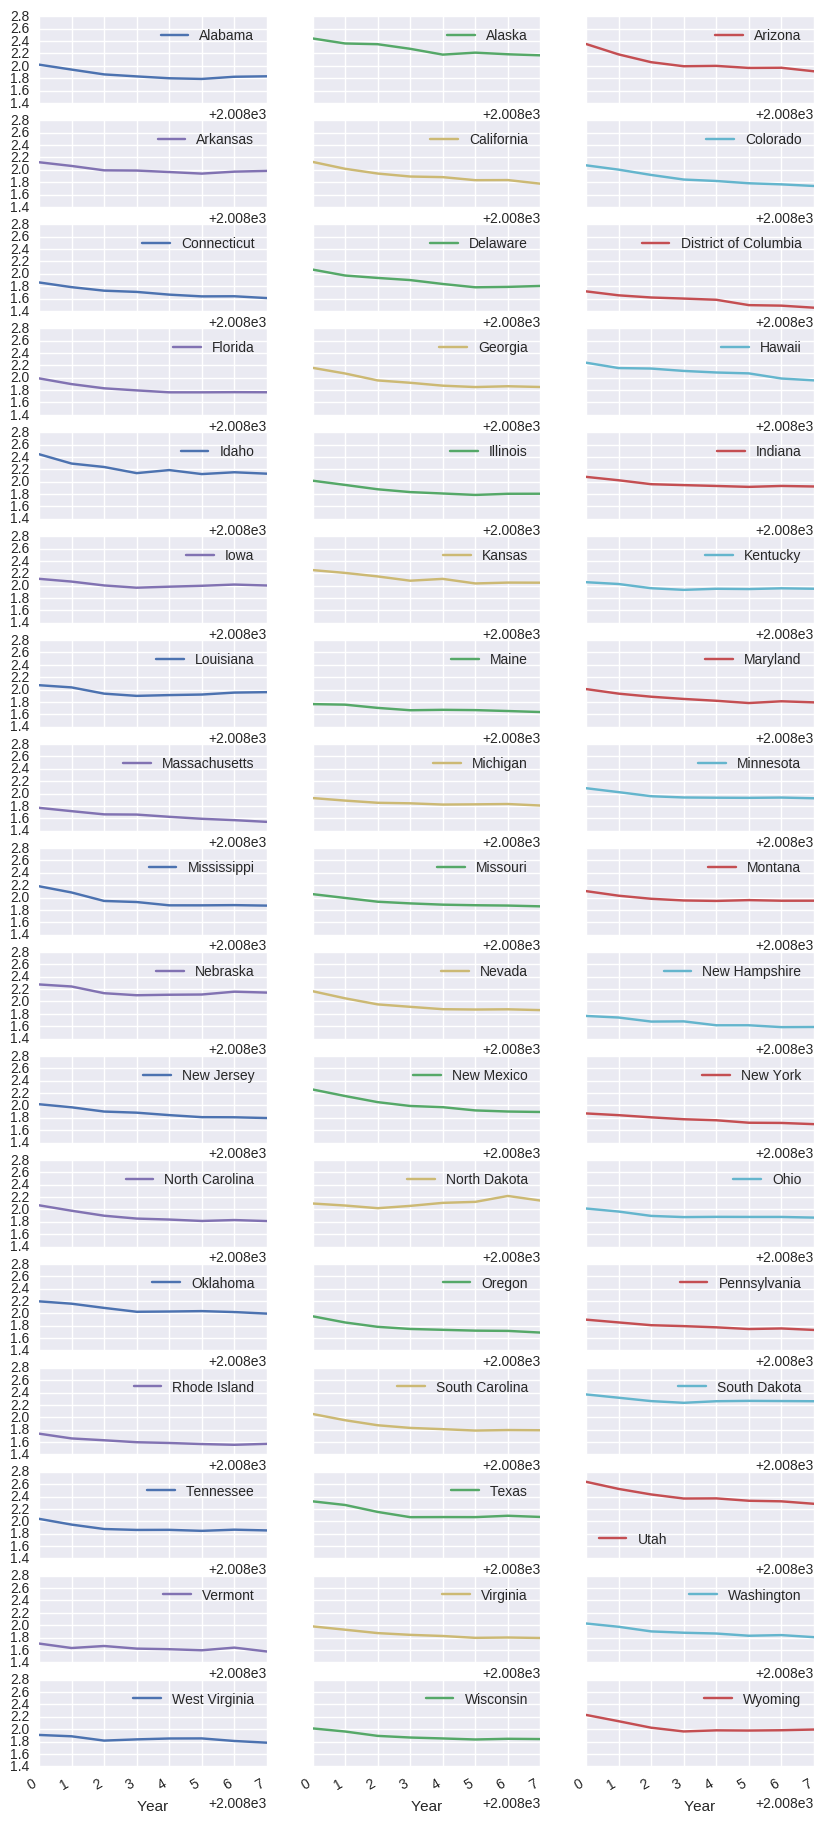

In [43]:
(tfr.unstack(level=0)
        .plot(subplots=True, 
              layout=(17,3 ), 
              figsize=(10, 25),
              sharey=True,
              sharex=True
              ));

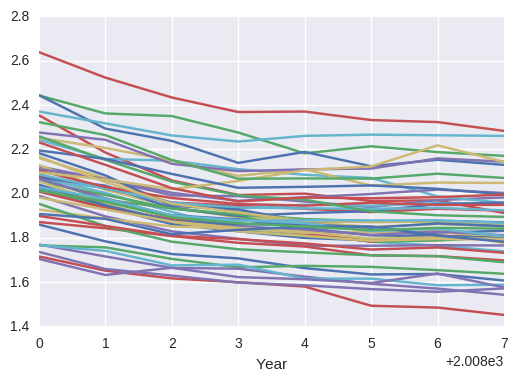

In [48]:
(tfr.unstack(level=0)
    .plot(legend=False));

### Distribution of TFR by year

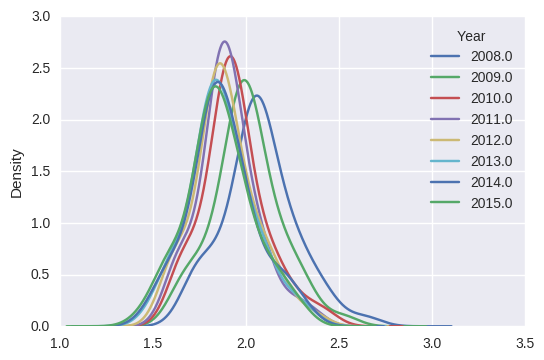

In [57]:
tfr.unstack(level=1).plot(kind='density')

In [61]:
tfr.to_csv('state_tfr.csv')

### State level Geo Distribution

In [64]:
HTML('<iframe width="100%" height="520" frameborder="0" src="https://team.carto.com/u/stuartlynn/builder/fd28d1f4-f490-11e6-90a6-0e05a8b3e3d7/embed" allowfullscreen webkitallowfullscreen mozallowfullscreen oallowfullscreen msallowfullscreen></iframe>')

## County level results

In [67]:
tfr_counties = counties.groupby(['County','Year']).sum()["Fertility Rate"].div(1000.)
tfr_counties.head()

County          Year  
Ada County, ID  2007.0    2.169744
                2008.0    2.104331
                2009.0    1.921144
                2010.0    1.845475
                2011.0    1.854574
Name: Fertility Rate, dtype: float64

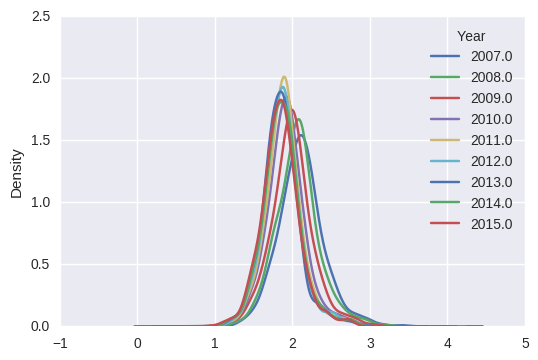

In [68]:
tfr_counties.unstack(level=1).plot(kind='density')

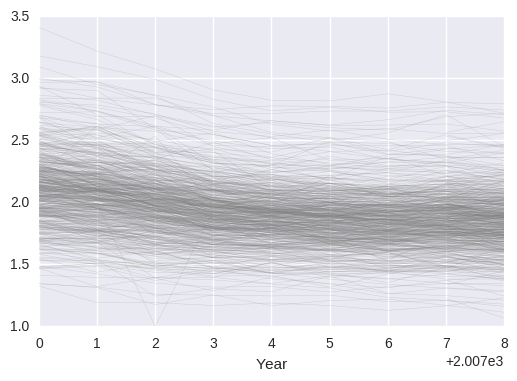

In [76]:
(tfr_counties.unstack(level=0)
    .plot(legend=False, c='grey', alpha=0.3,lw=0.3 ));